In [0]:
!pip install fastai2 -q

In [0]:
from fastai2.vision.all import *

In [33]:
source = untar_data(URLs.MNIST_TINY)
items = get_image_files(source)
fn = items[0]; fn

Path('/root/.fastai/data/mnist_tiny/train/7/8107.png')

# Transform

In [34]:
img = PILImage.create(fn); img

In [35]:
tconv = ToTensor()
img = tconv(img)
img.shape, type(img)

(torch.Size([3, 28, 28]), fastai2.torch_core.TensorImage)

In [36]:
img[:3, :3, :3]

tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=torch.uint8)

In [37]:
lbl = parent_label(fn); lbl

'7'

In [38]:
tcat = Categorize(vocab=['3', '7'])
lbl = tcat(lbl); lbl

TensorCategory(1)

In [39]:
lbld = tcat.decode(lbl); lbld

'7'

# Pipeline

เราสามารถเอา Transform หลาย ๆ อัน มาต่อกัน ให้ทำงานตามลำดับ เหมือนด้านบน ด้วย Pipeline

In [40]:
pipe = Pipeline([PILImage.create, tconv])
img = pipe(img)

img.shape, type(img)

(torch.Size([3, 28, 28]), fastai2.torch_core.TensorImage)

สามารถสั่ง show ได้ด้วย Pipeline จะรู้เองว่าต้องแปลงกลับอย่างไร ให้เป็นรูปต้นฉบับ เพื่อการแสดงผลที่ถูกต้อง

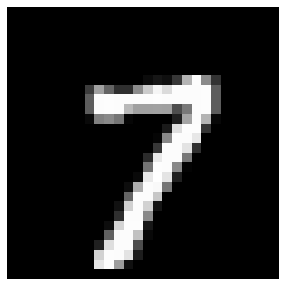

In [41]:
pipe.show(img, figsize=(5, 5), cmap='Greys');

# Creating custom Transform

เราจะมาลองสร้าง Transform ใช้เองกัน

ติดตั้ง albumentation ที่ใช้ในการทำ Data Augmentation รูปภาพ

In [0]:
! pip install albumentations -q

เราจะใช้ Pets Dataset ที่เป็นรูปสี ความละเอียดสูง จะได้เห็น Data Augmentation ชัดขึ้น กว่า ตัวเลขขาวดำ ภาพเล็ก ๆ

In [0]:
source = untar_data(URLs.PETS)
items = get_image_files(source/"images")

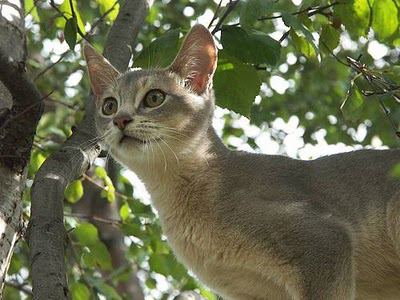

In [85]:
img = PILImage.create(items[0])
img

In [0]:
from albumentations import ShiftScaleRotate

In [0]:
aug = ShiftScaleRotate(p=1)

In [0]:
def aug_tfm(img):
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return PILImage.create(aug_img)

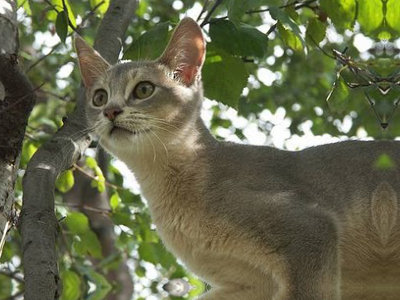

In [94]:
aug_tfm(img)

เราสามารถ สร้าง Transform ใหม่ ได้ด้วยการ pass function ให้ Transform โดยตรง

In [0]:
tfm = Transform(aug_tfm)

หรือสร้าง Class ขึ้นมาใหม่ โดยเราสามารถกำหนด Type ของ input ของ encodes ได้ ในเคสนี้ คือ PILImage ถ้าไม่ใช่ก็จะปล่อยผ่าน ไม่ทำงาน เราสามารถกำหนดได้หลาย Method รองรับหลาย Type เป็น Polymorphism

In [0]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug=aug
    def encodes(self, img:PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

ลองใช้งานดู

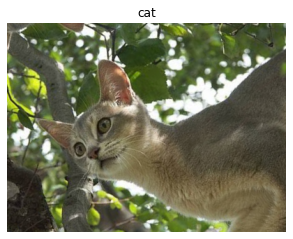

In [98]:
tfm = AlbumentationsTransform(ShiftScaleRotate(p=1))
a, b = tfm((img, 'cat'))
show_image(a, title=b);

# Transform whole tuple

แทนที่เราจะ Transform แยกกัน ระหว่าง Input และ Label เราสามารถกำหนดให้ Transform รับทั้งสองอย่างมาเป็น Tuple ได้เลย ด้วยการ inherit จาก ItemTransform

ในเคสนี้ เราจะใช้ Camvid Dataset จะได้เห็นภาพชัด เนื่องจากเป็นรูปเหมือนกัน ทั้ง Input และ Label แต่ต้องการ Transform ที่แตกต่างกัน คือ Image และ Mask

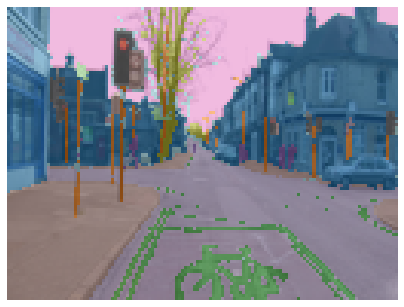

In [51]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/"images")
img = PILImage.create(cv_items[0])
mask = PILMask.create(cv_source/'labels'/f'{cv_items[0].stem}_P{cv_items[0].suffix}')
ax = img.show(figsize=(7, 7))
ax = mask.show(ctx=ax)

เราจะสร้าง class ใหม่ ที่ subclass จาก ItemTransform ทำให้ encodes รับ x, y พร้อมกัน เป็น Tuple

In [0]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug=aug
    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug['image']), PILMask.create(aug['mask'])

ลองใช้ดู

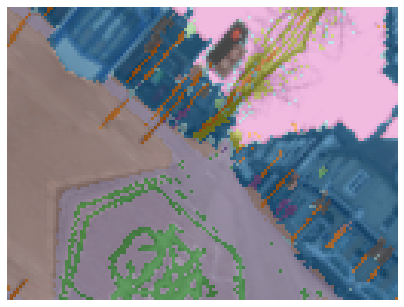

In [53]:
tfm = SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))
a, b = tfm((img, mask))
ax = a.show(figsize=(7, 7))
ax = b.show(ctx=ax)

We can reverse behavior by define decodes method and define setup to create some initial states.

เมื่อมี encodes เราก็ควรกำหนด decodes ในการแปลงกลับ เพื่อใช้ในการแสดงผล นอกจากนี้ใน subclass ItemTransform เรายังสามารถสร้าง setup method ในการกำหนดค่าเริ่มต้น

# Try use only Transform 

In [54]:
source = untar_data(URLs.PETS)/"images"
items = get_image_files(source)
len(items)

7390

make image same size and covert to tensor

In [0]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz, sz))
    return tensor(array(x)).permute(2, 0, 1).float()/255.

define how TitledImage type show itself with show method.

In [0]:
class TitledImage(Tuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

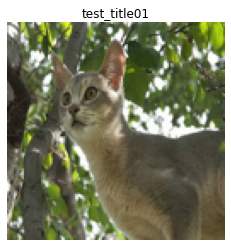

In [57]:
img = resized_image(items[0])
TitledImage(img, 'test_title01').show()

# Decodes to reverse process

ในการแสดงผล เราจำเป็นต้องใช้ decodes method ในการแปลง Tensor และ De-Normalize กลับเป็นรูปภาพต้นฉบับ และ แปลง CategoryTensor กลับเป็น Label ที่เราสามารถอ่านได้เข้าใจ

In [0]:
class PetTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab, self.o2i, self.lblr = vocab, o2i, lblr
    def encodes(self, o): return [resized_image(o), self.o2i[self.lblr(o)]]
    def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

* lblr = Labeler such as parent_labeler
* o2i = Object to Index / Label to Index
* vocab = Vocab Dictionary

In [0]:
labeller = using_attr(RegexLabeller(pat=r'^(.*)_\d+.jpg$'), 'name')

In [68]:
labeller(items[0]), items[0]

('Abyssinian',
 Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_79.jpg'))

In [0]:
vals = list(map(labeller, items))
vocab, o2i = uniqueify(vals, sort=True, bidir=True)

In [71]:
pets = PetTfm(vocab, o2i, labeller)
pets

PetTfm: (object,object) -> encodes (object,object) -> decodes

In [74]:
x, y = pets(items[0])
x.shape, y

(torch.Size([3, 128, 128]), 0)

ลอง decodes กลับ

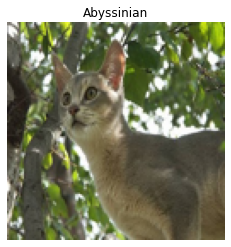

In [81]:
dec = pets.decode([x, y])
dec.show()

In [0]:
class PetTfm(ItemTransform):
    def __init__(self, vocab, o2i, lblr): self.vocab, self.o2i, self.lblr = vocab, o2i, lblr
    def encodes(self, o): return (resized_image(o), self.o2i(self.lblr(o)))
    def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

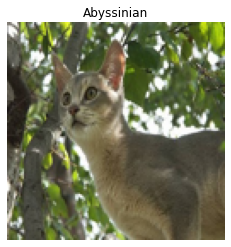

In [83]:
dec = pets.decode(pets(items[0]))
dec.show()